<a href="https://colab.research.google.com/github/yaeliavni/Applied-Statistics/blob/main/marketing_pymc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   scipy import stats
import statsmodels.api as sm
import arviz as az
import pymc  as pm
import math


df = (
    pd.read_csv("/content/marketing.csv", sep=";", decimal=',')   # ;-delimited
      .replace(",", ".", regex=True)        # swap ,→.
      .astype(float)                        # cast to floats
)

# תקנון של המשתנים
for col in ["youtube", "facebook", "newspaper", "sales"]:
    df[f"{col}_std"] = (df[col] - df[col].mean()) / df[col].std()

df.head()

,youtube,facebook,newspaper,sales,youtube_std,facebook_std,newspaper_std,sales_std
0,276.12,45.36,83.04,26.52,0.967425,0.979066,1.774493,1.548168
1,53.40,47.16,54.12,12.48,-1.194379,1.080097,0.667903,-0.694304
2,20.64,55.08,83.16,11.16,-1.512360,1.524637,1.779084,-0.905135
3,181.80,49.56,70.20,22.20,0.051919,1.214806,1.283185,0.858177
4,216.96,12.96,70.08,15.48,0.393196,-0.839507,1.278593,-0.215143


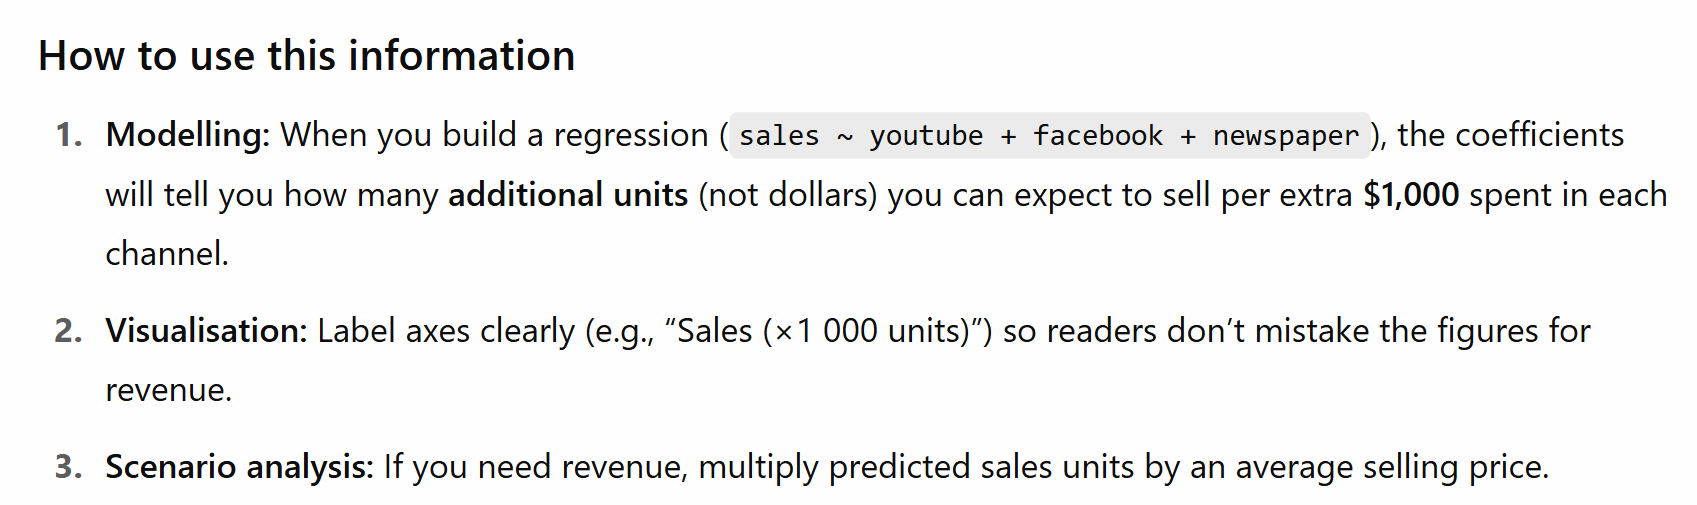

# Classical (Frequentist) Linear Regression               
OLS gives point estimates; Bayesian gives full posterior

In [2]:
X = df[["youtube_std", "facebook_std", "newspaper_std"]]
sm.OLS(df.sales_std, sm.add_constant(X)).fit()

# הגישה הבייסיאנית

image.png

Output()

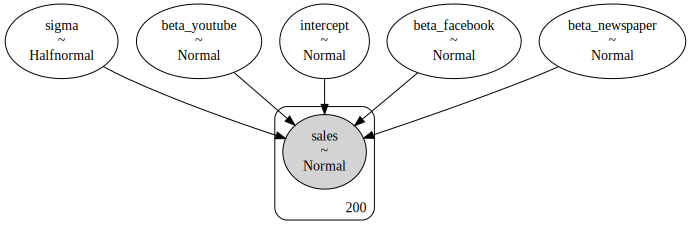

In [3]:
with pm.Model() as marketing_model:
    intercept      = pm.Normal("intercept",      mu=0, sigma=10)
    beta_youtube   = pm.Normal("beta_youtube",   mu=0, sigma=1)
    beta_facebook  = pm.Normal("beta_facebook",  mu=0, sigma=1)
    beta_newspaper = pm.Normal("beta_newspaper", mu=0, sigma=1) #סיגמא=1 כי עשינו תקנון לכולם mu=0 יענו תוחלת וסטיית תקן:
    sigma          = pm.HalfNormal("sigma",      sigma=5) # כי צריך התפלגות שהתומך שלה בין 0 ל אינסוף או חצי נורמלי או חצי קושי

    mu = (
        intercept
        + beta_youtube   * df.youtube_std
        + beta_facebook  * df.facebook_std
        + beta_newspaper * df.newspaper_std
    ) # mu is the expected sales

    sales = pm.Normal("sales", mu=mu, sigma=sigma, observed=df.sales_std)
    idata_flat = pm.sample(
        1000,
        tune=1000,
        chains=2,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True},
    )



pm.model_to_graphviz(marketing_model)


זה המודל הראשון שבנינו, בעיקרון רגרסיה לינארית בבסייאנית, ומאוד דומה ללאסו בקלאסית.

Output()

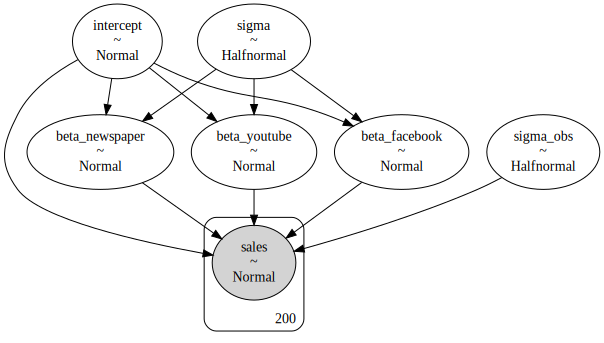

In [4]:
with pm.Model() as marketing_model1:
    # Hyperpriors
    intercept = pm.Normal("intercept", mu=0, sigma=10)    # group-level mean
    sigma     = pm.HalfNormal("sigma", sigma=1)           # group-level SD

    beta_youtube   = pm.Normal("beta_youtube",   mu=intercept, sigma=sigma)
    beta_facebook  = pm.Normal("beta_facebook",  mu=intercept, sigma=sigma)
    beta_newspaper = pm.Normal("beta_newspaper", mu=intercept, sigma=sigma)

    sigma_obs = pm.HalfNormal("sigma_obs", sigma=5)

    mu_sales = (
        intercept
        + beta_youtube   * df.youtube_std
        + beta_facebook  * df.facebook_std
        + beta_newspaper * df.newspaper_std
    )

    sales = pm.Normal("sales", mu=mu_sales, sigma=sigma_obs, observed=df.sales_std)

    idata_hier = pm.sample(
        1000,
        tune=1000,
        chains=2,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True},
    )

pm.model_to_graphviz(marketing_model1)


sigma for coefficients and sigma_obs for data noise
and we use shrinkage to make data/"weaker" weighted data go towards the group's mean and std.

In [5]:
model_dict = {
    "flat": idata_flat,
    "hier": idata_hier,
}
model_obj  = {"flat": marketing_model,
              "hier": marketing_model1}

summary_vars = {
    "flat": ["intercept",
             "beta_youtube", "beta_facebook", "beta_newspaper",
             "sigma"],
    "hier": ["sigma_obs",
             "beta_youtube", "beta_facebook", "beta_newspaper",
             "sigma", "intercept"],
}

In [6]:
for label, idata in model_dict.items():
    print(f"\n### {label.upper()} MODEL  –  az.summary ###")
    display(az.summary(idata, var_names=summary_vars[label]))


### FLAT MODEL  –  az.summary ###


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.001,0.023,-0.041,0.042,0.000,0.000,2678.0,1635.0,1.0
beta_youtube,0.752,0.023,0.714,0.798,0.001,0.001,1971.0,1603.0,1.0
beta_facebook,0.536,0.025,0.488,0.580,0.001,0.001,1870.0,1549.0,1.0
beta_newspaper,-0.004,0.024,-0.051,0.040,0.001,0.001,2048.0,1478.0,1.0
sigma,0.325,0.016,0.293,0.355,0.000,0.000,2500.0,1669.0,1.0



### HIER MODEL  –  az.summary ###


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_obs,0.325,0.016,0.294,0.354,0.000,0.000,2795.0,1534.0,1.00
beta_youtube,0.752,0.024,0.706,0.794,0.000,0.001,2716.0,1634.0,1.00
beta_facebook,0.535,0.025,0.487,0.581,0.000,0.001,2603.0,1560.0,1.00
beta_newspaper,-0.003,0.024,-0.049,0.043,0.001,0.000,2396.0,1581.0,1.00
sigma,0.720,0.327,0.263,1.294,0.007,0.011,2928.0,1496.0,1.01
intercept,0.003,0.023,-0.039,0.047,0.000,0.001,2875.0,1359.0,1.00


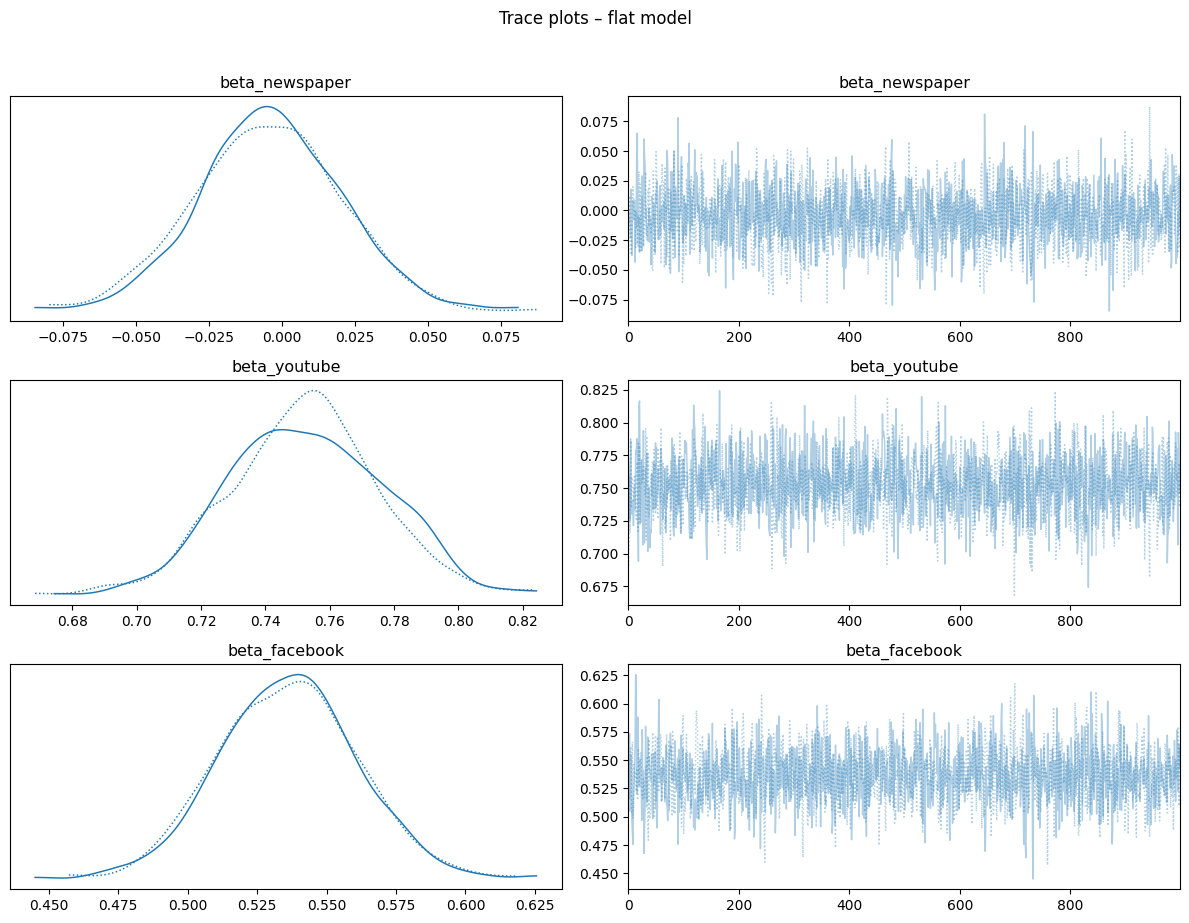

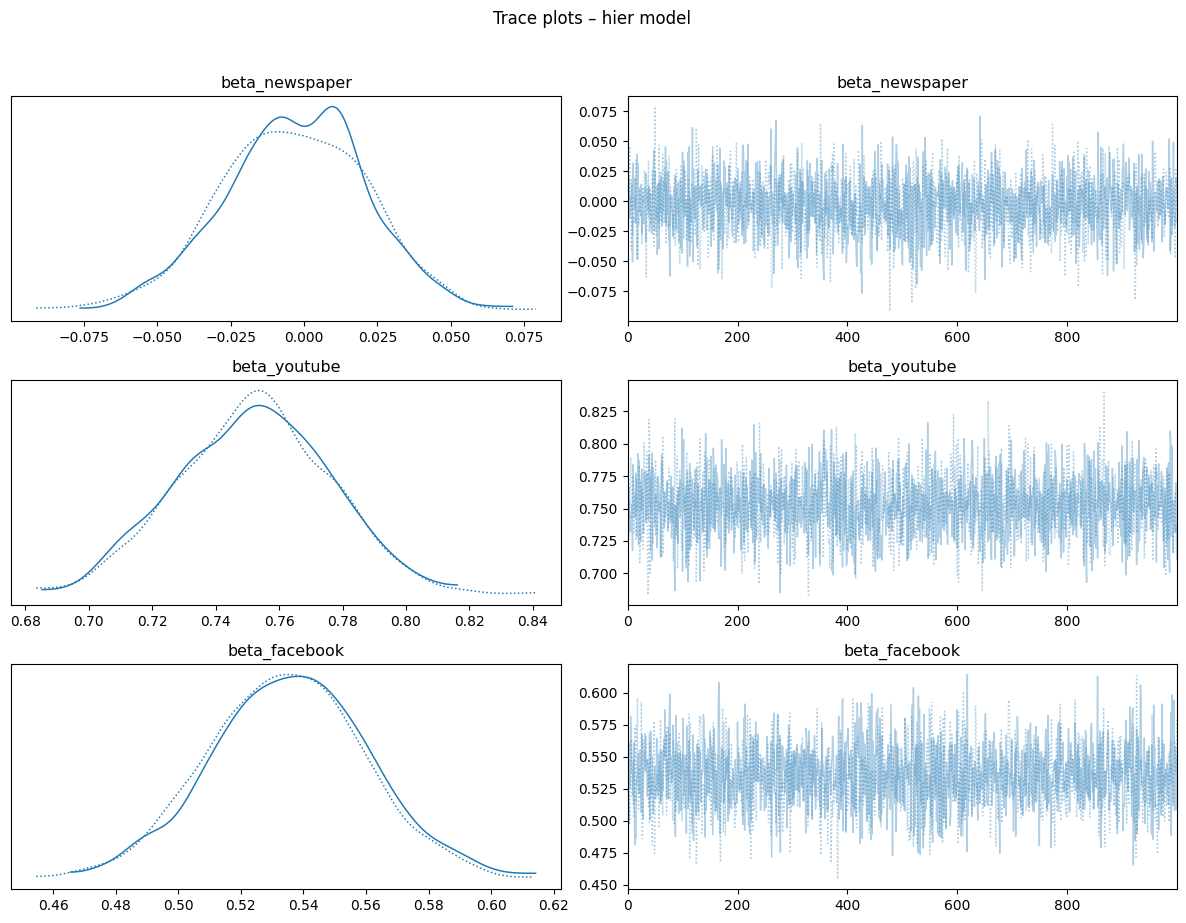

In [7]:
trace_vars = ["beta_newspaper", "beta_youtube", "beta_facebook"]

for label, idata in model_dict.items():
    az.plot_trace(
        idata,
        var_names = trace_vars,
        compact   = True,
        figsize   = (12, 3*len(trace_vars)),
    )
    plt.suptitle(f"Trace plots – {label} model", y=1.02)
    plt.tight_layout()
    plt.show()

בגרפים משמאל, כל קו הוא שרשרת מרקוב ואנחנו רוצים שהם כמה שיותר יהיו חופפים

מימין, זה מוודא שאין תלות בין דגימה לדגימה כי בסוף אנחנו דוגמים כל פעם מהשכן של
הדגימה הנוכחית.
ואם משווים את זה לקלאסית, זה כמו להסתכל על השאריות ולראות שהם מתפלגים נורמלי
\
On the left-hand marginal density you see the tick at the parameter value where the divergence happened.

On the right-hand trace panel you see the same tick at the iteration index where it occurred.

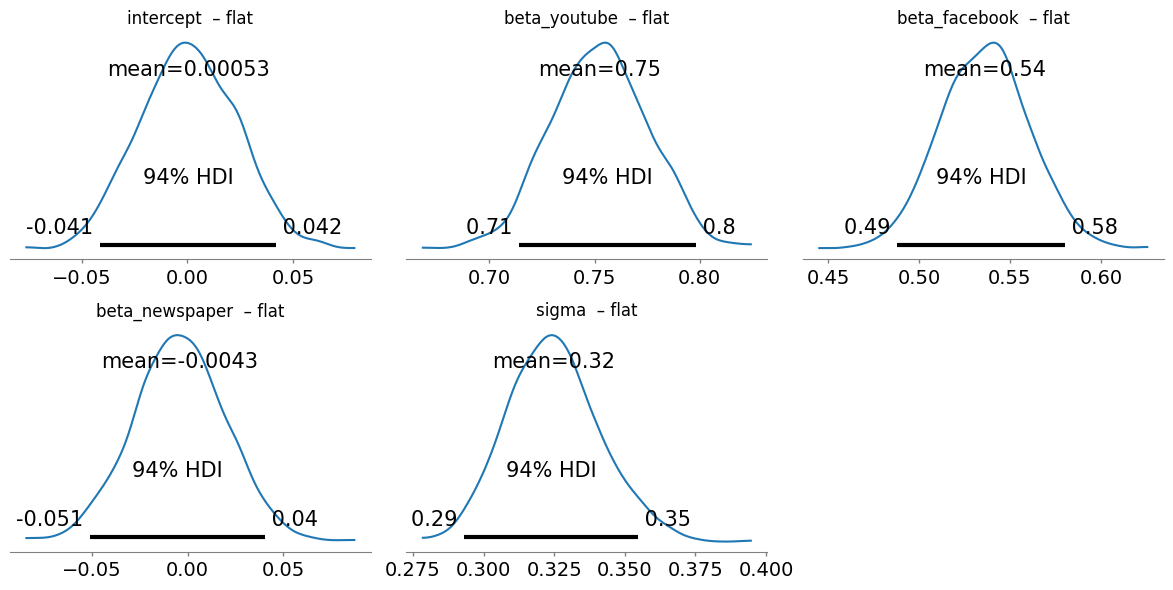

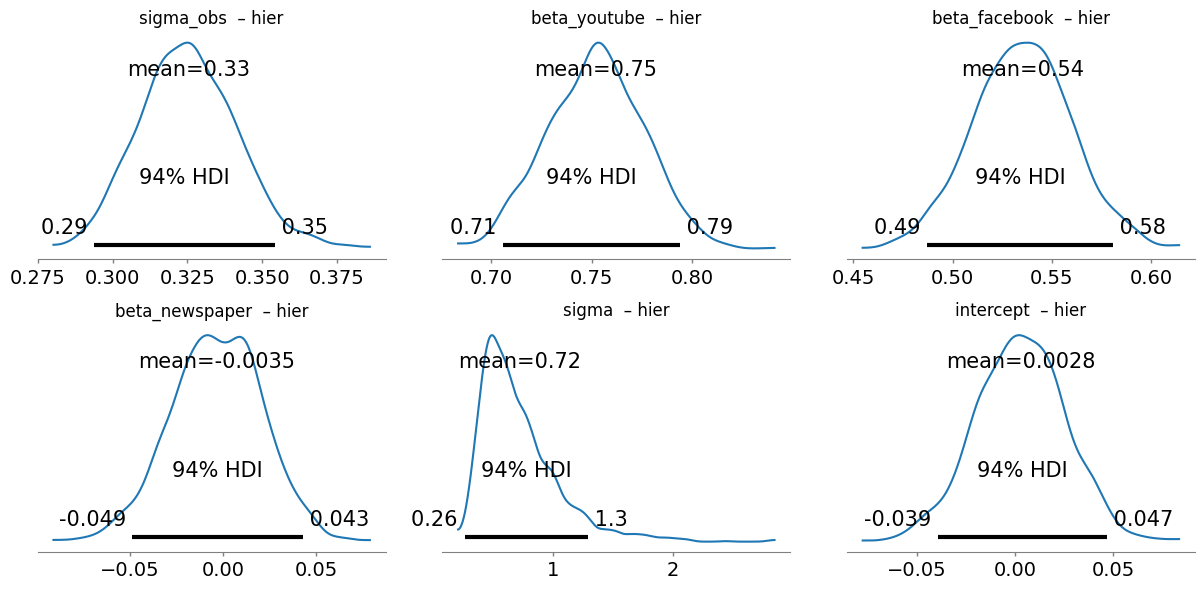

In [8]:
for label, idata in model_dict.items():
    vars_to_plot       = summary_vars[label]
    n_cols, n_rows     = 3, math.ceil(len(vars_to_plot)/3)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows), squeeze=False)
    for idx, var in enumerate(vars_to_plot):
        r, c = divmod(idx, n_cols) #turns a flat index into row+col positions.
        az.plot_posterior(
            idata,
            var_names=[var],
            hdi_prob=0.94,
            kind="kde",
            point_estimate="mean",
            ax=axes[r][c],
        )
        axes[r][c].set(title=f"{var}  – {label}")
    # drop any unused axes
    for idx in range(len(vars_to_plot), n_rows*n_cols):
        fig.delaxes(axes.flatten()[idx])
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.tight_layout()
    plt.show()




Called credability intervals בבסייאנית

compare probability vs frequency



# ייצור הדגימות של הפוסטיריור


In [9]:
az.summary(idata_flat)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_facebook,0.536,0.025,0.488,0.580,0.001,0.001,1870.0,1549.0,1.0
beta_newspaper,-0.004,0.024,-0.051,0.040,0.001,0.001,2048.0,1478.0,1.0
beta_youtube,0.752,0.023,0.714,0.798,0.001,0.001,1971.0,1603.0,1.0
intercept,0.001,0.023,-0.041,0.042,0.000,0.000,2678.0,1635.0,1.0
sigma,0.325,0.016,0.293,0.355,0.000,0.000,2500.0,1669.0,1.0


In [10]:
idata_flat

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [11]:
az.summary(idata_hier)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_facebook,0.535,0.025,0.487,0.581,0.000,0.001,2603.0,1560.0,1.00
beta_newspaper,-0.003,0.024,-0.049,0.043,0.001,0.000,2396.0,1581.0,1.00
beta_youtube,0.752,0.024,0.706,0.794,0.000,0.001,2716.0,1634.0,1.00
intercept,0.003,0.023,-0.039,0.047,0.000,0.001,2875.0,1359.0,1.00
sigma,0.720,0.327,0.263,1.294,0.007,0.011,2928.0,1496.0,1.01
sigma_obs,0.325,0.016,0.294,0.354,0.000,0.000,2795.0,1534.0,1.00


In [12]:
idata_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Bayes Factor - אם ירצו לפרסם את הדברים בעיתונות:)

In [13]:
def draw_hier_prior(size=10_000): #It simulates from the hierarchical prior so we can estimate the prior density at 0
    mu     = np.random.normal(0, 10,   size)        # intercept prior
    sigma  = np.abs(np.random.normal(0, 1, size))   # HalfNormal(1)
    return {
        "beta_youtube":   np.random.normal(mu, sigma),
        "beta_facebook":  np.random.normal(mu, sigma),
        "beta_newspaper": np.random.normal(mu, sigma),
    }

prior_draws_flat = {
    "beta_youtube":   np.random.normal(0, 1, 10_000),
    "beta_facebook":  np.random.normal(0, 1, 10_000),
    "beta_newspaper": np.random.normal(0, 1, 10_000),
}
prior_draws_hier = draw_hier_prior()


The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.
/usr/local/lib/python3.12/dist-packages/arviz/plots/backends/matplotlib/bfplot.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


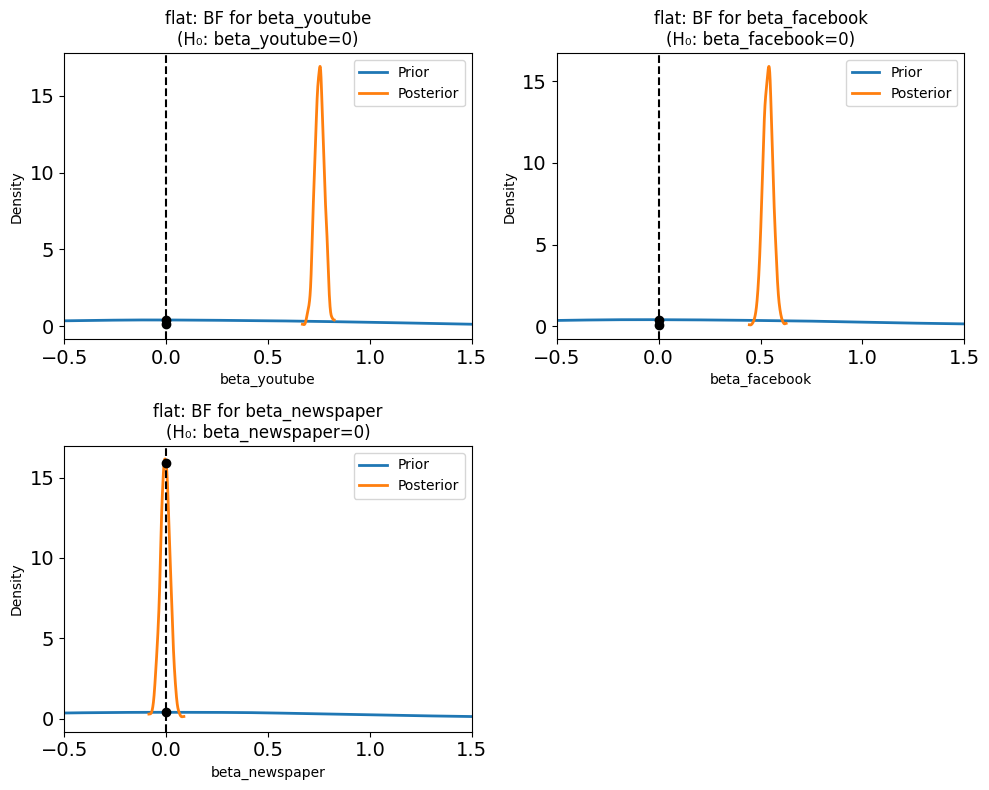

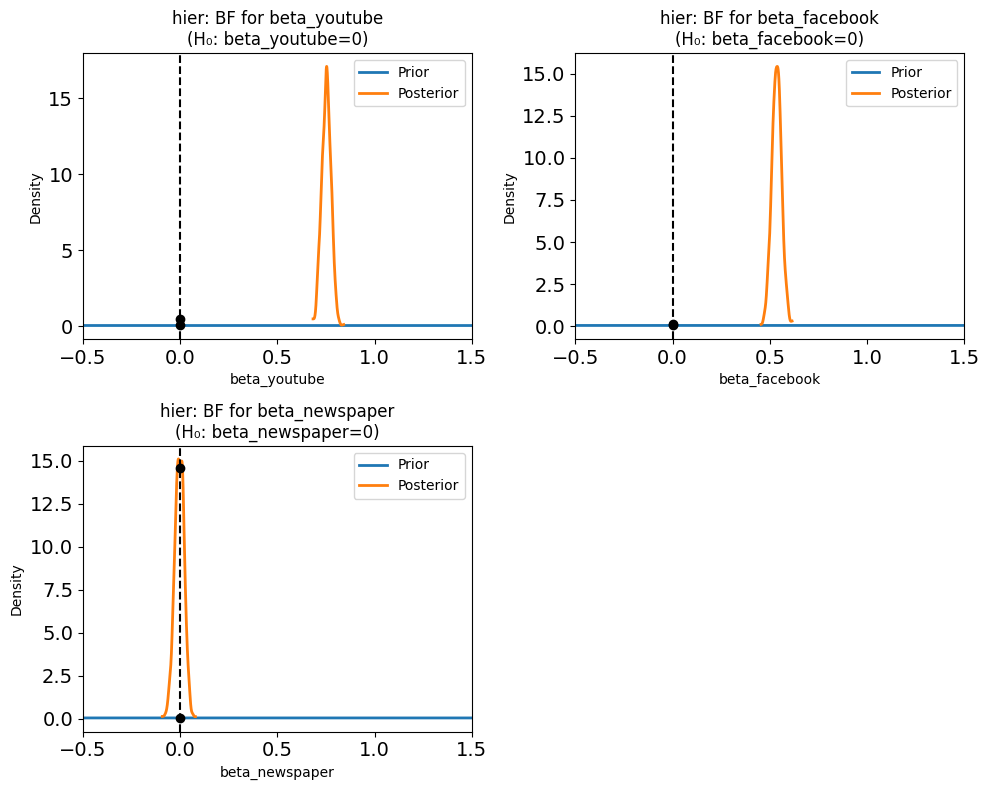

In [14]:
vars_plot   = ["beta_youtube", "beta_facebook", "beta_newspaper"]

for label, idata in model_dict.items():
    priors = prior_draws_flat if label=="flat" else prior_draws_hier

    n_cols, n_rows = 2, math.ceil(len(vars_plot)/2)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,4*n_rows), squeeze=False)

    for i, var in enumerate(vars_plot):
        ax = axes.flatten()[i]
        az.plot_bf(
            idata,
            var_name = var,
            prior    = priors[var],
            ref_val  = 0.0,
            ax       = ax,
            plot_kwargs={"linewidth":2},
        )
        ax.set_xlim(-0.5, 1.5)
        ax.set_title(f"{label}: BF for {var}\n(H₀: {var}=0)")

    # drop unused axes
    for j in range(len(vars_plot), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])
    plt.tight_layout()
    plt.show()


 איך הפוסטיריור יבחר נקודה אחת לעת הצורך, לעיתונות או להכניס בטבלת אקסל.
לתוחלת זה MSE L2
לחציון זה MAE L1

flat  | beta_youtube    | L2* = 0.752 vs  mean = 0.752 | L1* = 0.752 vs median = 0.753
flat  | beta_facebook   | L2* = 0.536 vs  mean = 0.536 | L1* = 0.536 vs median = 0.536
flat  | beta_newspaper  | L2* = -0.005 vs  mean = -0.004 | L1* = -0.005 vs median = -0.005


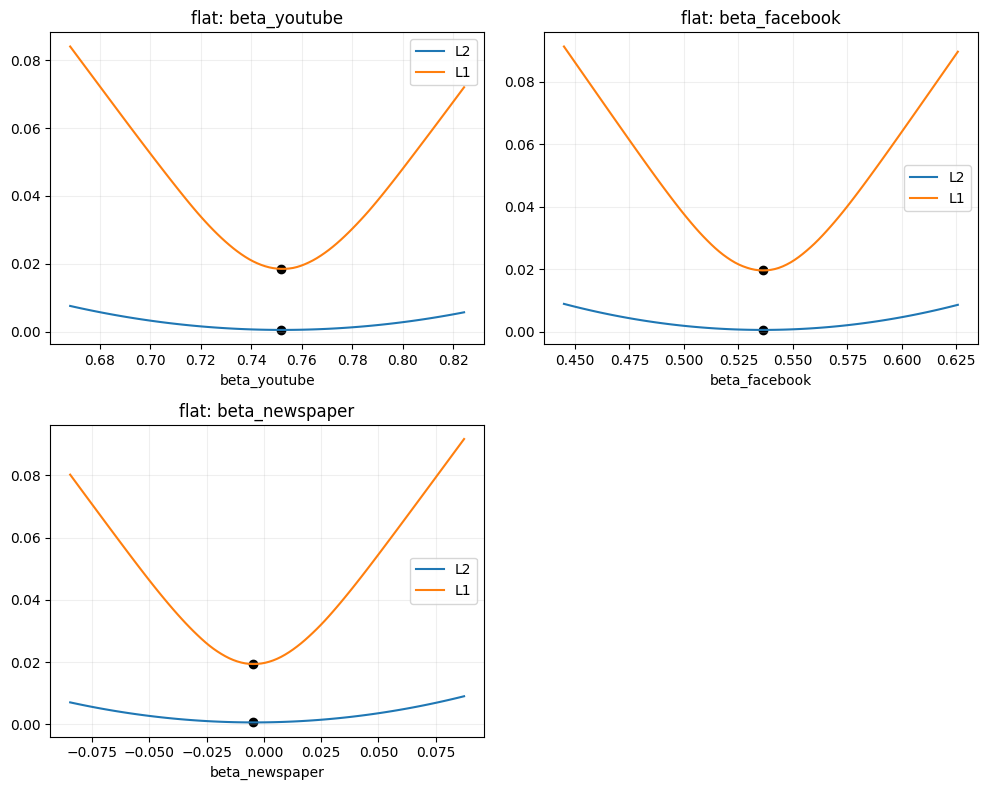

hier  | beta_youtube    | L2* = 0.752 vs  mean = 0.752 | L1* = 0.752 vs median = 0.752
hier  | beta_facebook   | L2* = 0.535 vs  mean = 0.535 | L1* = 0.535 vs median = 0.536
hier  | beta_newspaper  | L2* = -0.004 vs  mean = -0.003 | L1* = -0.004 vs median = -0.003


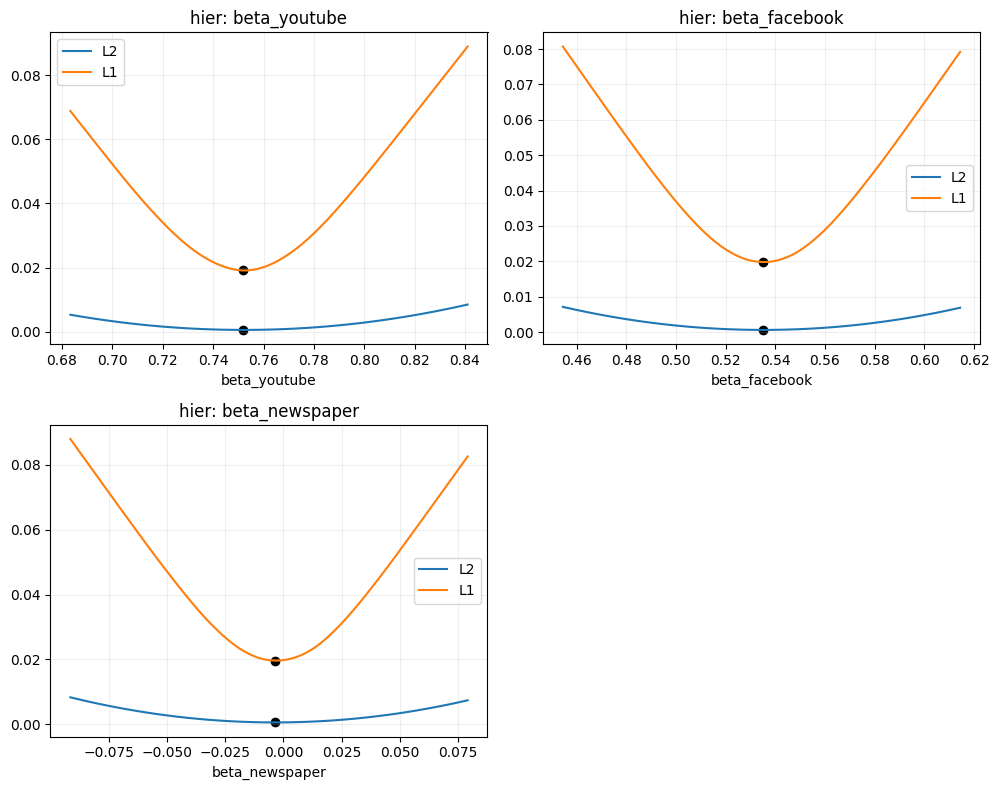

In [15]:
# coefficients we care about
beta_vars = ["beta_youtube", "beta_facebook", "beta_newspaper"]

for label, idata in model_dict.items():     # idata is an InferenceData object
    n_cols, n_rows = 2, math.ceil(len(beta_vars)/2)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4*n_rows), squeeze=False)

    for ax, var in zip(axes.flatten(), beta_vars):
        post   = idata.posterior[var].values.flatten()
        x_grid = np.linspace(post.min(), post.max(), 100)

        # L2 (squared-error) and L1 (absolute-error) losses
        L2 = np.mean((post[:, None] - x_grid[None, :])**2, axis=0)
        L1 = np.mean(np.abs(post[:, None] - x_grid[None, :]), axis=0)

        # minimisers of each loss
        x2, x1 = x_grid[L2.argmin()], x_grid[L1.argmin()]

        print(f"{label:5s} | {var:15s} | "
              f"L2* = {x2:.3f} vs  mean = {post.mean():.3f} | "
              f"L1* = {x1:.3f} vs median = {np.median(post):.3f}")

        ax.plot(x_grid, L2, label="L2")
        ax.plot(x_grid, L1, label="L1")
        ax.scatter([x2, x1], [L2.min(), L1.min()], color="k")
        ax.set(title=f"{label}: {var}", xlabel=var)
        ax.legend(); ax.grid(alpha=0.2)

    # hide any unused panels (e.g. 3 vars on a 2×2 grid leaves 1 blank)
    for extra_ax in axes.flatten()[len(beta_vars):]:
        extra_ax.set_visible(False)

    plt.tight_layout(); plt.show()


# Posterior-predictive checks

Output()

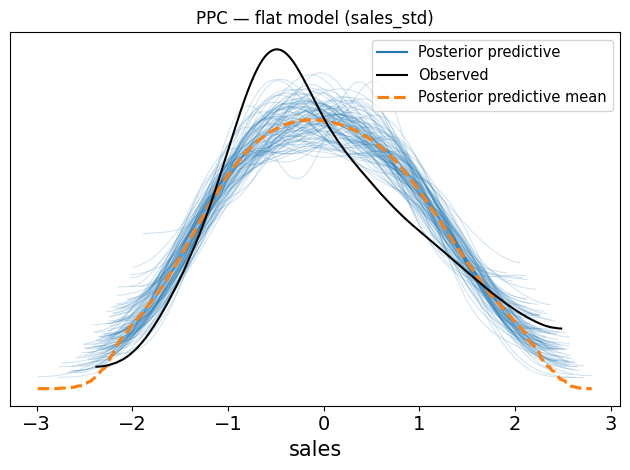

Output()

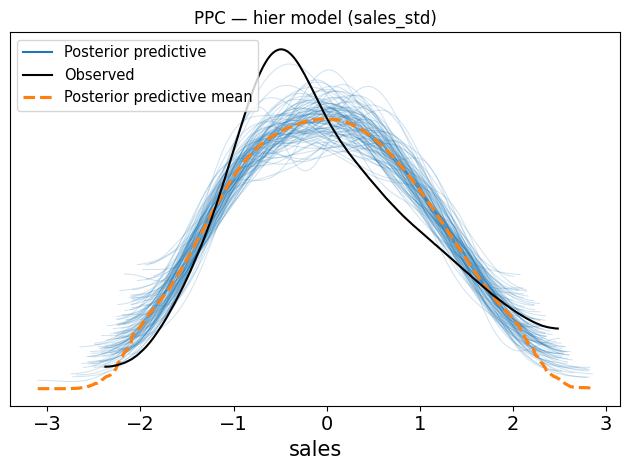

In [17]:
for label in model_dict:
    idata = model_dict[label]
    mdl   = model_obj[label]

    #Draw posterior-predictive samples for "sales"
    with mdl:
        ppc = pm.sample_posterior_predictive(
            idata, var_names=["sales"], random_seed=42
        )
    idata.extend(ppc)          # adds a posterior_predictive group

    # KDE overlay of PPC vs observed (standardised)
    az.plot_ppc(idata, data_pairs={"sales": "sales"},
                num_pp_samples=100, kind="kde")
    plt.title(f"PPC — {label} model (sales_std)")
    plt.tight_layout(); plt.show()

    #Because we standardised earlier, we multiply by the original SD and add the original mean to reverse the z-score.
    mean_p = ppc.posterior_predictive["sales"].mean(dim=("chain", "draw"))
    hdi94 = az.hdi(ppc.posterior_predictive["sales"], hdi_prob=0.94)

    df[f"sales_pred_mean_{label}"]  = mean_p * df.sales.std() + df.sales.mean()
    df[f"sales_pred_lower_{label}"] = hdi94.sel(hdi="lower") * df.sales.std() + df.sales.mean()
    df[f"sales_pred_upper_{label}"] = hdi94.sel(hdi="higher")* df.sales.std() + df.sales.mean()

סימלצנו דאטא מהמודל, השוונו אותו עם קיידיאי של הדאטא האמיתי

#Model Comparison


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
flat,0,-62.532420,8.017272,0.000000,1.0,17.455004,0.000000,False,log
hier,1,-62.557464,7.985968,0.025045,0.0,17.372500,0.162594,False,log


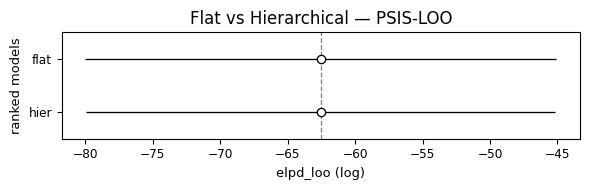

In [18]:
# PSIS-LOO (default if you omit ic=)
cmp_loo = az.compare({"flat": idata_flat, "hier": idata_hier}, ic="loo")

display(cmp_loo)
az.plot_compare(cmp_loo)
plt.title("Flat vs Hierarchical — PSIS-LOO")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
flat,0,-62.551209,8.036061,0.000000,1.0,17.495295,0.000000,True,log
hier,1,-62.575002,8.003505,0.023793,0.0,17.406328,0.169258,True,log



PSIS-LOO:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
flat,0,-62.532420,8.017272,0.000000,1.0,17.455004,0.000000,False,log
hier,1,-62.557464,7.985968,0.025045,0.0,17.372500,0.162594,False,log


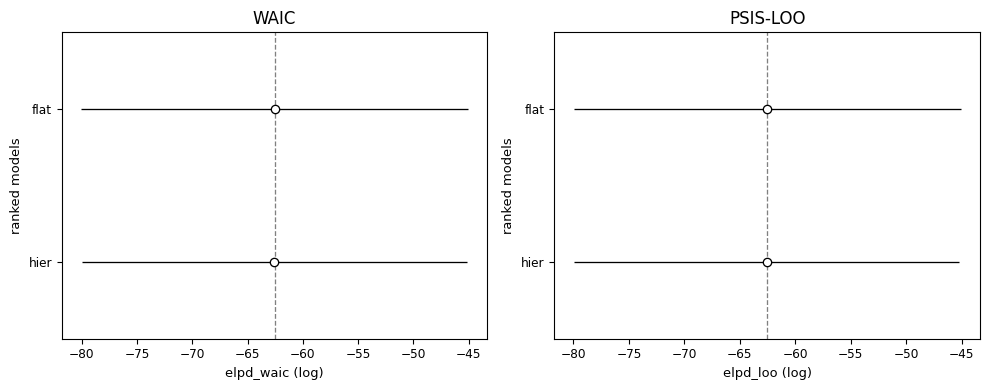

In [19]:
cmp_waic = az.compare({"flat": idata_flat, "hier": idata_hier}, ic="waic")
cmp_loo  = az.compare({"flat": idata_flat, "hier": idata_hier}, ic="loo")

print("WAIC:")
display(cmp_waic)

print("\nPSIS-LOO:")
display(cmp_loo)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

az.plot_compare(cmp_waic, ax=ax[0]); ax[0].set_title("WAIC")
az.plot_compare(cmp_loo,  ax=ax[1]); ax[1].set_title("PSIS-LOO")

plt.tight_layout(); plt.show()


 Lower WAIC / higher LOO-ELPD is better

בקלאסית
 Think AIC or BIC, but derived from the entire posterior, not just one MLE point.

